## Общая идея:
* Каждая точка начинается как свой собственный кластер.

* На каждом шаге объединяются два наиболее похожих (близких) кластера.

* Это продолжается до тех пор, пока:

    * Не останется один кластер, или

    * Не достигнуто желаемое количество кластеров k.

## Шаги алгоритма:
1. Инициализация: 
Каждый объект — это отдельный кластер:
n объектов → n кластеров.

2. Вычисление расстояний: 
Посчитай расстояние между кластерами. Это зависит от метода связи (linkage).

3. Найди 2 кластера с минимальным расстоянием: 
Их мы объединяем.

4. Обнови матрицу расстояний: 
После объединения необходимо пересчитать расстояния между новым кластером и всеми остальными.

5. Повторяй: 
Повторяем шаги 3–4, пока не будет достигнуто заданное количество кластеров k

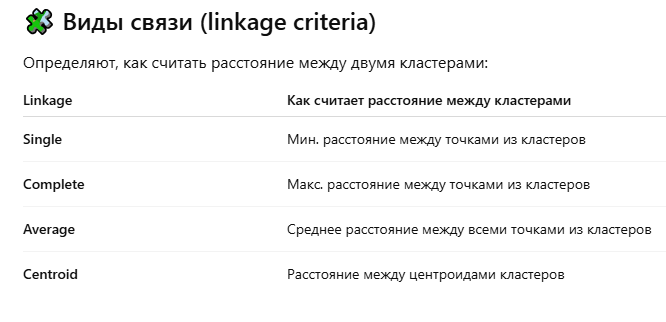

In [1]:
from IPython.display import Image
Image('linkage.png')

## Плюсы:
* Не требует заранее знать k (можно построить всю дендрограмму).
* Хорошо работает с различными формами кластеров (в зависимости от linkage).
* Простой и интерпретируемый.

## Минусы:
* Медленный для больших данных (O(n^3) при наивной реализации).
* Чувствителен к выбору расстояний и выбросам.

In [2]:
import math

def euclidean_distance(p1, p2):
    return math.sqrt(sum((a - b) ** 2 for a, b in zip(p1, p2)))

def single_linkage_distance(cluster1, cluster2):
    return min(euclidean_distance(p1, p2) for p1 in cluster1 for p2 in cluster2)


In [5]:
import numpy as np

def cluster_distance(cluster1, cluster2, data):
    return max(np.linalg.norm(data[i] - data[j]) for i in cluster1 for j in cluster2)


In [6]:
def agglomerative_clustering(data, n_clusters):
    # Изначально каждый объект — отдельный кластер
    clusters = [[i] for i in range(len(data))]

    # Пока не останется нужное количество кластеров
    while len(clusters) > n_clusters:
        min_dist = float('inf')
        merge_idx = (0, 1)

        # Находим пару кластеров с минимальным расстоянием
        for i in range(len(clusters)):
            for j in range(i + 1, len(clusters)):
                dist = cluster_distance(clusters[i], clusters[j], data)
                if dist < min_dist:
                    min_dist = dist
                    merge_idx = (i, j)

        # Объединяем найденные два ближайших кластера
        i, j = merge_idx
        clusters[i] = clusters[i] + clusters[j]
        clusters.pop(j)

    # Создаем метки для точек
    labels = [None] * len(data)
    for cluster_id, cluster in enumerate(clusters):
        for index in cluster:
            labels[index] = cluster_id

    return labels


In [4]:
def fit_predict(data, k):
    clusters = agglomerative_clustering(data, k)
    
    labels = [None] * len(data)
    for cluster_id, cluster in enumerate(clusters):
        for point in cluster:
            index = data.index(point)  # требует, чтобы все точки уникальны
            labels[index] = cluster_id
    return labels


Adjusted Rand Index (My vs True): 0.2898502551022331
Adjusted Rand Index (Sklearn vs True): 0.2898502551022331
NMI (My vs True): 0.2285563138559593
NMI (Sklearn vs True): 0.2285563138559593


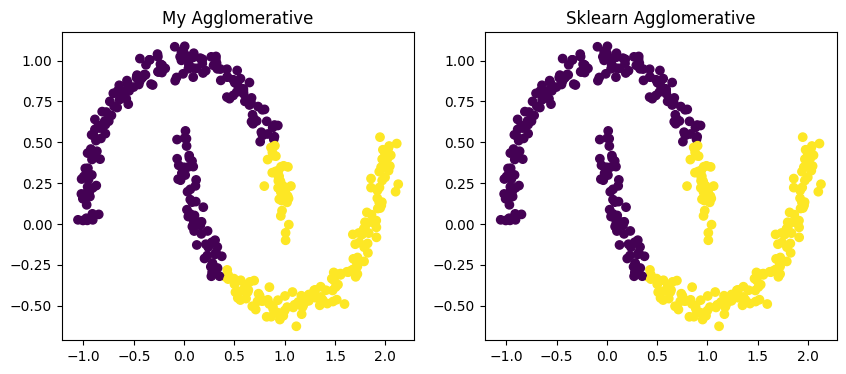

In [7]:
from sklearn.datasets import make_moons
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.cluster import AgglomerativeClustering as SkAgglo
import matplotlib.pyplot as plt

# Данные
X, y_true = make_moons(n_samples=400, noise=0.05)

# Наша реализация
my_labels = agglomerative_clustering(X, n_clusters=2)

# Sklearn
sk_labels = SkAgglo(n_clusters=2, linkage='complete').fit_predict(X)

# Сравнение метрик
print("Adjusted Rand Index (My vs True):", adjusted_rand_score(y_true, my_labels))
print("Adjusted Rand Index (Sklearn vs True):", adjusted_rand_score(y_true, sk_labels))
print("NMI (My vs True):", normalized_mutual_info_score(y_true, my_labels))
print("NMI (Sklearn vs True):", normalized_mutual_info_score(y_true, sk_labels))

# Визуализация
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=my_labels)
plt.title("My Agglomerative")

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=sk_labels)
plt.title("Sklearn Agglomerative")

plt.show()


In [8]:
import numpy as np
from sklearn.metrics import pairwise_distances
from collections import defaultdict

class AgglomerativeClustering:
    def __init__(self, n_clusters=2, linkage="average"):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.labels_ = None

    def fit(self, X):
        self.X = X
        self.n_samples = X.shape[0]
        self.clusters = {i: [i] for i in range(self.n_samples)}
        self.dist_matrix = pairwise_distances(X)
        self._init_cache()

        while len(self.clusters) > self.n_clusters:
            c1, c2 = self._find_closest_clusters()
            self._merge_clusters(c1, c2)

        self._create_labels()
        return self

    def _init_cache(self):
        # Кэш для среднего/полного расстояния между кластерами
        self.linkage_cache = {}

    def _find_closest_clusters(self):
        min_dist = float("inf")
        closest = (None, None)

        cluster_ids = list(self.clusters.keys())
        for i in range(len(cluster_ids)):
            for j in range(i + 1, len(cluster_ids)):
                c1, c2 = cluster_ids[i], cluster_ids[j]
                dist = self._compute_linkage_distance(c1, c2)
                if dist < min_dist:
                    min_dist = dist
                    closest = (c1, c2)
        return closest

    def _compute_linkage_distance(self, c1, c2):
        key = frozenset((c1, c2))
        if key in self.linkage_cache:
            return self.linkage_cache[key]

        cluster1 = self.clusters[c1]
        cluster2 = self.clusters[c2]

        if self.linkage == "single":
            dist = np.min(self.dist_matrix[np.ix_(cluster1, cluster2)])
        elif self.linkage == "complete":
            dist = np.max(self.dist_matrix[np.ix_(cluster1, cluster2)])
        elif self.linkage == "average":
            dist = np.mean(self.dist_matrix[np.ix_(cluster1, cluster2)])
        elif self.linkage == "ward":
            # centroid distance squared × size1 × size2 / (size1 + size2)
            X1 = self.X[cluster1]
            X2 = self.X[cluster2]
            centroid1 = np.mean(X1, axis=0)
            centroid2 = np.mean(X2, axis=0)
            dist = np.sum((centroid1 - centroid2) ** 2)
            dist *= len(cluster1) * len(cluster2) / (len(cluster1) + len(cluster2))
        else:
            raise ValueError(f"Unknown linkage: {self.linkage}")

        self.linkage_cache[key] = dist
        return dist

    def _merge_clusters(self, c1, c2):
        self.clusters[c1].extend(self.clusters[c2])
        del self.clusters[c2]

        # Удалить старые кэши, связанные с c2
        keys_to_delete = [k for k in self.linkage_cache if c2 in k]
        for k in keys_to_delete:
            del self.linkage_cache[k]

    def _create_labels(self):
        self.labels_ = np.empty(self.n_samples, dtype=int)
        for cluster_id, indices in enumerate(self.clusters.values()):
            for i in indices:
                self.labels_[i] = cluster_id


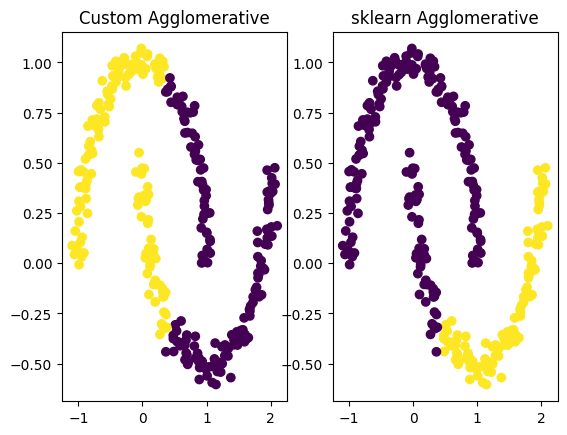

In [9]:
from sklearn.datasets import make_moons
from sklearn.cluster import AgglomerativeClustering as SkAgg
import matplotlib.pyplot as plt

X, _ = make_moons(n_samples=300, noise=0.05)

# Твоя реализация
my_model = AgglomerativeClustering(n_clusters=2, linkage="average")
my_model.fit(X)
my_labels = my_model.labels_

# sklearn
sk_model = SkAgg(n_clusters=2, linkage="average")
sk_labels = sk_model.fit_predict(X)

# Визуализация
plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=my_labels, cmap="viridis")
plt.title("Custom Agglomerative")

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=sk_labels, cmap="viridis")
plt.title("sklearn Agglomerative")
plt.show()


In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram
from sklearn.datasets import make_blobs
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances

In [38]:
import numpy as np
from sklearn.datasets import make_blobs
from sklearn.preprocessing import normalize
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt

class AgglomerativeClustering:
    def __init__(self, n_clusters=2, linkage="average"):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.clusters = {}
        self.labels_ = None
        self.linkage_cache = {}
        self.merges = []  # List of merges for dendrogram
        self.next_cluster_id = 0  # Unique ID for new clusters

    def fit(self, X):
        self.n_samples = len(X)
        self.X = normalize(X)
        self.dist_matrix = cdist(self.X, self.X)  # Use cdist for pairwise distances
        self.next_cluster_id = self.n_samples  # Start new IDs from n_samples

        # Initialize clusters: each point is a separate cluster
        self.clusters = {i: [i] for i in range(self.n_samples)}
        self.cluster_sizes = {i: 1 for i in range(self.n_samples)}  # Cluster sizes

        while len(self.clusters) > self.n_clusters:
            c1, c2 = self._closest_clusters()
            self._merge_clusters(c1, c2)

        self._assign_labels()

    def _assign_labels(self):
        self.labels_ = np.empty(self.n_samples, dtype=int)
        for label, points in enumerate(self.clusters.values()):
            for point in points:
                self.labels_[point] = label

    def _closest_clusters(self):
        min_dist = float("inf")
        closest_pair = None
        keys = list(self.clusters.keys())

        for i in range(len(keys)):
            for j in range(i + 1, len(keys)):
                c1, c2 = keys[i], keys[j]
                key = tuple(sorted((c1, c2)))

                if key in self.linkage_cache:
                    dist = self.linkage_cache[key]
                else:
                    dist = self._compute_linkage_distance(c1, c2)
                    self.linkage_cache[key] = dist

                if dist < min_dist:
                    min_dist = dist
                    closest_pair = (c1, c2)

        return closest_pair

    def _compute_linkage_distance(self, c1, c2):
        points1 = self.clusters[c1]
        points2 = self.clusters[c2]
        dists = self.dist_matrix[np.ix_(points1, points2)]

        if self.linkage == "single":
            return dists.min()
        elif self.linkage == "complete":
            return dists.max()
        elif self.linkage == "average":
            return dists.mean()
        else:
            raise ValueError("Unsupported linkage type")

    def _merge_clusters(self, c1, c2):
        dist = self._compute_linkage_distance(c1, c2)
        size1 = self.cluster_sizes[c1]
        size2 = self.cluster_sizes[c2]
        total_size = size1 + size2

        # Create new cluster with unique ID
        new_cluster_id = self.next_cluster_id
        self.next_cluster_id += 1
        self.merges.append([c1, c2, dist, total_size])

        # Merge clusters
        self.clusters[new_cluster_id] = self.clusters[c1] + self.clusters[c2]
        self.cluster_sizes[new_cluster_id] = total_size

        # Remove old clusters
        del self.clusters[c1]
        del self.clusters[c2]
        del self.cluster_sizes[c1]
        del self.cluster_sizes[c2]

        # Clear cache
        keys_to_delete = [k for k in self.linkage_cache if c1 in k or c2 in k]
        for k in keys_to_delete:
            del self.linkage_cache[k]

    def get_linkage_matrix(self):
        # Create linkage matrix
        n = self.n_samples
        linkage_matrix = np.zeros((n - self.n_clusters, 4))
        id_map = {i: i for i in range(n)}  # Map original and new cluster IDs

        for i, (c1, c2, dist, size) in enumerate(self.merges):
            # Get the current IDs for c1 and c2
            idx1 = id_map[c1]
            idx2 = id_map[c2]
            # Assign the new cluster ID (n + i)
            new_id = n + i
            linkage_matrix[i] = [idx1, idx2, dist, size]
            # Update id_map for the new cluster
            id_map[c1] = new_id
            id_map[c2] = new_id
            id_map[new_id] = new_id

        return linkage_matrix

def plot_dendrogram(linkage_matrix):
    plt.figure(figsize=(10, 6))
    dendrogram(linkage_matrix)
    plt.title("Hierarchical Clustering Dendrogram")
    plt.xlabel("Objects")
    plt.ylabel("Distance")
    plt.show()

In [39]:
X, y = make_blobs(n_samples=10, centers=3, random_state=42)
model = AgglomerativeClustering(n_clusters=3, linkage="average")
model.fit(X)

print("Labels:", model.labels_)

linkage_matrix = model.get_linkage_matrix()
print("Linkage Matrix:\n", linkage_matrix)
plot_dendrogram(linkage_matrix)

Labels: [0 0 2 0 1 1 1 2 2 1]
Linkage Matrix:
 [[4.00000000e+00 5.00000000e+00 6.91592716e-03 2.00000000e+00]
 [9.00000000e+00 1.00000000e+01 2.90576810e-02 3.00000000e+00]
 [0.00000000e+00 3.00000000e+00 3.58939645e-02 2.00000000e+00]
 [2.00000000e+00 7.00000000e+00 1.11820128e-01 2.00000000e+00]
 [1.00000000e+00 1.20000000e+01 1.62294654e-01 3.00000000e+00]
 [6.00000000e+00 1.10000000e+01 2.20040658e-01 4.00000000e+00]
 [8.00000000e+00 1.30000000e+01 3.55501006e-01 3.00000000e+00]]


ValueError: Linkage 'Z' uses non-singleton cluster before it is formed.

<Figure size 1000x600 with 0 Axes>